The notebook verifies the ternary Hamiltonian recognition algorithm in [1] that matches the claim in Theorem 3. Note that the package `quairkit` is required to run the notebook. The package can be installed by running `pip install quairkit`.

In [1]:
import torch
import quairkit as qkit
from quairkit import Circuit
from quairkit.loss import Measure
from quairkit.database import *

import numpy as np
from numpy.polynomial.polynomial import Polynomial
from numpy.polynomial.chebyshev import cheb2poly
from typing import Tuple

from wx_angles import alg_find_Q, alg_find_Phi, Phi_verification

qkit.set_dtype('complex128')

## Algorithm of Ternary Hamiltonian Recognition

**Input**: $k$ copies of an evolution dynamic $U_{H}(\theta) = e^{-iH \theta}$, where $k$ is odd, $t \in \mathbb{R}$ is unknown and $H$ is an unknown Hamiltonian from a known set $\{X, Y, Z\}$.

**Output**: 2 bits as a guess of $H$, where '00' and '10' stands for $Z$, '01' stands for $Y$ and '11' stands for $X$.

### Step 1. Compute Angle

Determine two vectors of angles $\vec{\phi_x} = \phi_{x, 0}, \ldots, \phi_{x, k}$ and $\vec{\phi_y} = \phi_{y, 0}, \ldots, \phi_{y, k}$ such that
$$
\begin{aligned}
R_z(\phi_{x, 0}) \prod_{j=1}^k W_x(a) R_z(\phi_{x, j}) &= \begin{pmatrix}
    P(a) & -i Q^*(a) \sqrt{1 - a^2} \\
    i Q(a) \sqrt{1 - a^2} & P(a)
\end{pmatrix}, \\
R_z(\phi_{y, 0}) \prod_{j=1}^k W_x(a) R_z(\phi_{y, j}) &= \begin{pmatrix}
    P(a) & i Q(a) \sqrt{1 - a^2} \\
    i Q^*(a) \sqrt{1 - a^2} & P(a)
\end{pmatrix}
,\end{aligned}
$$
where $P = \frac{2}{k+1} \sum_{l=1,\,l\text{ odd}}^{k} T_l$. Here the angle computation logic is referred to Theorem 3-5 in [2], and is implemented by the qsvt module in [3].

In [2]:
def phi_set(k: int) -> Tuple[np.ndarray, np.ndarray]:
    r"""Compute the angle for the QSP circuit.
    
    Args:
        k: depth
        
    Returns:
        phi angles for Wx-based QSP
    
    """
    chebyshev_coef = np.zeros([k + 1])
    for i in range(k + 1):
        if i % 2 == 1:
            chebyshev_coef[i] = -1
    chebyshev_coef = chebyshev_coef * 2 / (k + 1)
    
    P = Polynomial(cheb2poly(chebyshev_coef))
    Q_x = alg_find_Q(P, k)
    Q_y = -1 * Polynomial(np.conj(Q_x.coef))
    
    Phi_x = alg_find_Phi(P, Q_x, k)
    Phi_y = alg_find_Phi(P, Q_y, k)
    return Phi_x * -2, Phi_y * -2

### Step 2: Construct circuit

Construct the three-qubit circuit

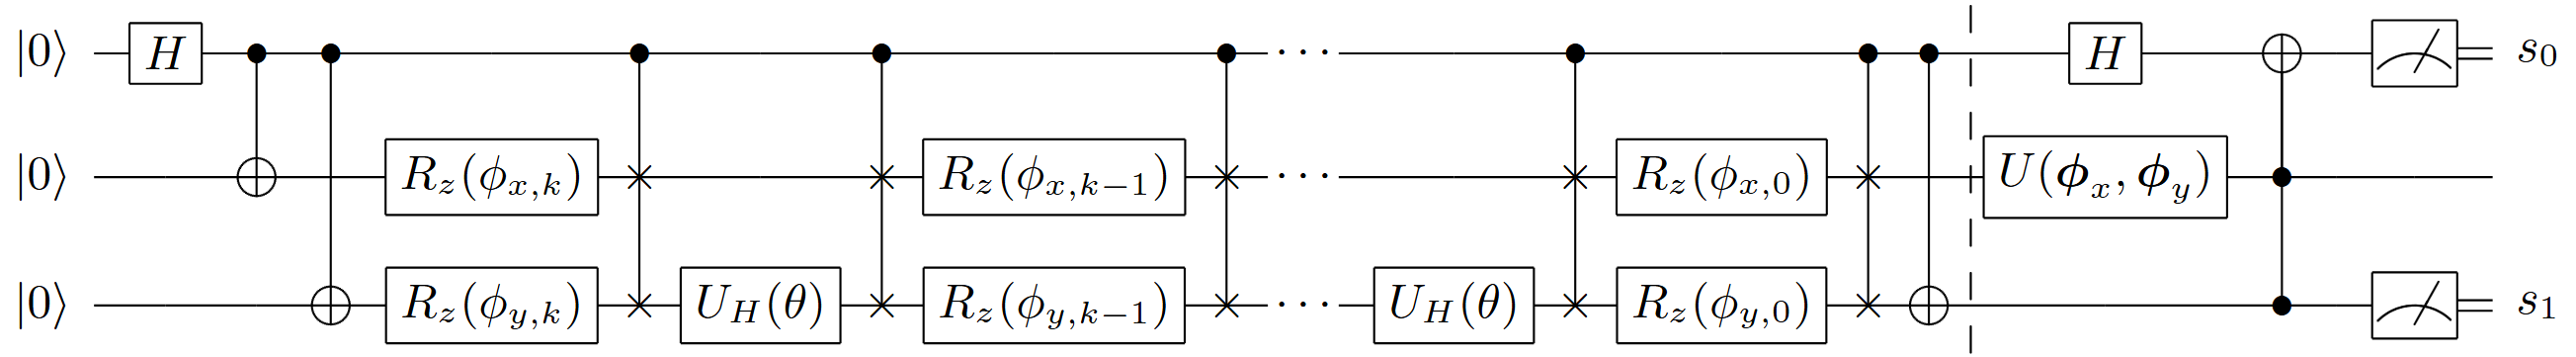

In [3]:
def _u(list_phi_x: np.ndarray, list_phi_y: np.ndarray) -> torch.Tensor:
    sum_phi_x, sum_phi_y = sum(list_phi_x), sum(list_phi_y)
    return torch.tensor([[np.exp(1j * sum_phi_y / 2), np.exp(-1j * sum_phi_x / 2)],
                         [np.exp(1j * sum_phi_x / 2), -1 * np.exp(-1j * sum_phi_y / 2)]]) / np.sqrt(2)

def _qsp(label: str, list_phi: Tuple[np.ndarray, np.ndarray], theta: np.ndarray) -> Circuit:
    list_phi_x, list_phi_y = list_phi
    
    cir = Circuit(3)
    cir.h(0)
    cir.cnot([0, 1])
    cir.cnot([0, 2])

    cir.rz([1, 2], param=[list_phi_x[0], list_phi_y[0]])

    for phi_x, phi_y in zip(list_phi_x[1:], list_phi_y[1:]):
        cir.cswap([0, 1, 2])
        if label == 'z':
            cir.rz(2, param=theta)
        elif label == 'y':
            cir.ry(2, param=theta)
        else:
            cir.rx(2, param=theta)
        cir.cswap([0, 1, 2])
        
        cir.rz([1, 2], param=[phi_x, phi_y])
    
    cir.cswap([0, 1, 2])
    cir.cnot([0, 2])
    cir.h(0)
    cir.oracle(_u(list_phi_x, list_phi_y), 1)
    cir.ccx([2, 1, 0])
    return cir

### Step 3: Run circuit

Input the zero state $\ket{000}$, run the circuit. Then perform a computational basis measurement at the end, and return the measurement outcome.

In [4]:
num_shot = 1000
M = Measure()

def algorithm2(label: str, k: int) -> float:
    r"""Implementation of the algorithm 2 for 1000 angles uniformly sampled from [0, 2 * pi).
    
    Args:
        label: label of the input unknown evolution operator
        k: number of available copies
    
    Returns:
        the experimental probability of correctly guessing the label
    
    """
    num_shot = 1000
    list_theta = np.linspace(0, 2 * np.pi, num_shot)

    list_phi = phi_set(k)
    cir = _qsp(label, list_phi, list_theta)
    output_state = cir()

    success_prob = M(output_state, system_idx=[0, 2]).mean(dim=0).tolist()

    if label == 'z':
        return success_prob[0] + success_prob[2]
    return success_prob[1] if label == 'y' else success_prob[3]

## Verification

Theorem 3 in [1] states that, the theoretical average success probability of this algorithm is $(3k + 1) / (3k + 3)$. We show that for odd $k \in \{3, \ldots, 15\}$, the worst experimental error is no larger than $0.001$.

In [5]:
def experiment(k: int) -> int:
    r"""Perform the experiment for a given k
    
    Args:
        k: number of available copies
    
    Returns:
        the experimental average probability of success
    
    """
    assert k % 2 == 1 and 3 <= k <= 15

    success_z = algorithm2('z', k)
    success_y = algorithm2('y', k)
    success_x = algorithm2('x', k)
    return (success_z + success_y + success_x) / 3

In [6]:
list_k = np.array([3, 5, 7, 9, 11, 13, 15])
list_ideal_success = ((3 * list_k + 1) / (3 * list_k + 3))

list_experiment_success = np.array([experiment(k) for k in list_k])

In [7]:
print('The maximal gap between the ideal and experimental success probability is', np.max(np.abs(list_ideal_success - list_experiment_success)))

The maximal gap between the ideal and experimental success probability is 0.0006250000001248868


---

## References

[1] C. Zhu, S. He, Y. Chen, L. Zhang, and X. Wang, Optimal Hamiltonian Recognition of Unknown Quantum Dynamics (2024), arXiv:2412.13067.

[2] A. Gilyén, Y. Su, G. H. Low, and N. Wiebe, Quantum singular value transformation and beyond: exponential improvements for quantum matrix arithmetics, in Proceedings of the 51st Annual ACM SIGACT Symposium on Theory of Computing, STOC 19 (ACM, 2019).

[3] Baidu Research Quantum, Paddle Quantum, 2020.

*Table: A reference of notation conventions.*

| Symbol        | Description                               |
|:---------------:|-------------------------------------------|
|  $\phi_j, \theta$ |  rotation angles  |
|  $R_x, R_z$ |   the rotation gates w.r.t. $x, z$ axis |
|  $W_x(a)$ |  $R_x(-2 \arccos(a))$  |
|  $T_l$ |  $l$-th Chebyshev polynomial of the first kind  |


In [8]:
qkit.print_info()


---------VERSION---------
quairkit: 0.3.0
torch: 2.5.1+cpu
numpy: 1.26.0
scipy: 1.14.1
matplotlib: 3.10.0
---------SYSTEM---------
Python version: 3.10.15
OS: Windows
OS version: 10.0.26100
---------DEVICE---------
CPU: ARMv8 (64-bit) Family 8 Model 1 Revision 201, Qualcomm Technologies Inc
